# 1. Information about the submission

## 1.1 Name and number of the assignment 

Argument Mining Competition (RuArg-2022), Assignment 2

## 1.2 Student name

**Solodnyova Ekaterina**

AIMasters

## 1.3 Codalab user ID

**katyanaveka**

# 2. Technical Report

## 2.1 Methodology 

I tried to use 2 pretrained models: mbert and rubert-tiny because these models are lighter than xmlr and rubert. I decided to use new model for each class.

I didn't choose hyperparameters clearly, only noticed that 5 epochs are enough to model for make eval_loss and train_loss equal, later there was inequality eval_loss > train_loss, so model might be overfited. With the same thoughts I choose learning rate. 

Firstly I decided to see how each model deals with task of classification by itself, then tried to make a simple ansamble: took an average of logits for each label which were predicted by each model.

Also I wanted to try some augmentations with the best model: use lemmas instead of initial text and to use paraphraser.

## 2.2 Discussion of results

***Enter here** a discussion of results and a summary of the experiment. Here we want to see the final table with comparison of the baseline and all tried approaches you decided to report. Even if some method did not bring you to the top of the leaderboard, you should nevertheless indicate this result and a discussion, why, in your opinion, some approach worked and another failed. Interesting findings in the discussion will be a plus.*

Method | Precision | Recall | F1 (from codalab submit)
--- | --- | --- | ---
Baseline | 0.88 | 0.77 |
base rubert-tiny model | - | - | 0.61
base mBert model with freezing layers| - | - | 0.49
base mBert model without freezing layers| - | - | 0.49
base (mBert+rubert-tiny)/2 | - | - | 0.57
rubert-tiny with lemmas | - | - | 0.50
rubert-tiny with all data and without stop words | - | - | 0.56

I didn't get it right how to use wandb with Trainer from transformer, so my plots and logs are very bad and I only had to look at the score and losses that were printed while training.

Sorry for plain logs in this notebook 😥


# 3. Code

## 3.1 Requirements

In [1]:
# pip install spacy
!pip install datasets transformers seqeval corus razdel pymorphy2 evaluate -q

## 3.2 Download the data

In [2]:
!wget https://raw.githubusercontent.com/dialogue-evaluation/RuArg/main/data/train.tsv
!wget https://raw.githubusercontent.com/dialogue-evaluation/RuArg/main/data/test-no_labels.tsv

--2023-04-23 14:55:43--  https://raw.githubusercontent.com/dialogue-evaluation/RuArg/main/data/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1539551 (1.5M) [text/plain]
Saving to: ‘train.tsv.1’

train.tsv.1         100%[===================>]   1.47M  --.-KB/s    in 0.04s   

2023-04-23 14:55:44 (34.5 MB/s) - ‘train.tsv.1’ saved [1539551/1539551]

--2023-04-23 14:55:45--  https://raw.githubusercontent.com/dialogue-evaluation/RuArg/main/data/test-no_labels.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 298180 (291K)

## 3.3 Preprocessing 

In [108]:
import pandas as pd

data = []
 
with open("/kaggle/working/train.tsv") as f:
    for line in f:
        l = line.replace('\n', '').split('\t')
        data.append(l)

In [109]:
df = pd.DataFrame(data[1:])
df.columns = data[0]
df.head(10)

,text_id,text,masks_stance,masks_argument,quarantine_stance,quarantine_argument,vaccines_stance,vaccines_argument
0,17024,"[USER], согласно предписаниям Роспотребнадзора...",-1,-1,1,1,-1,-1
1,17025,О несоблюдении карантинных мер контактными лиц...,-1,-1,1,1,-1,-1
2,17027,"[USER], читайте больше книжек на карантине, мо...",-1,-1,1,1,-1,-1
3,17030,Иди почитай инсту наших городских пабликов где...,-1,-1,1,1,-1,-1
4,17031,"Все контактные лица, которых они обозначили, о...",-1,-1,1,1,-1,-1
5,17033,"[USER], многие находятся на домашнем карантине",-1,-1,1,1,-1,-1
6,17034,Если бы сразу запретили перелеты и ввели каран...,-1,-1,2,1,-1,-1
7,17036,"[USER], надеемся, что в других регионах не при...",-1,-1,1,1,-1,-1
8,17037,"[USER], почему доктор зойдберг не имеет песню ...",1,1,1,1,-1,-1
9,17042,"вот из-за таких идиотов, которые ходят без мас...",2,1,2,1,-1,-1


In [116]:
labels_list = data[0][2:]
for label in labels_list:
    df[label] = df[label].astype(int)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


array([[<AxesSubplot:title={'center':'masks_stance'}>,
        <AxesSubplot:title={'center':'masks_argument'}>,
        <AxesSubplot:title={'center':'quarantine_stance'}>],
       [<AxesSubplot:title={'center':'quarantine_argument'}>,
        <AxesSubplot:title={'center':'vaccines_stance'}>,
        <AxesSubplot:title={'center':'vaccines_argument'}>]], dtype=object)

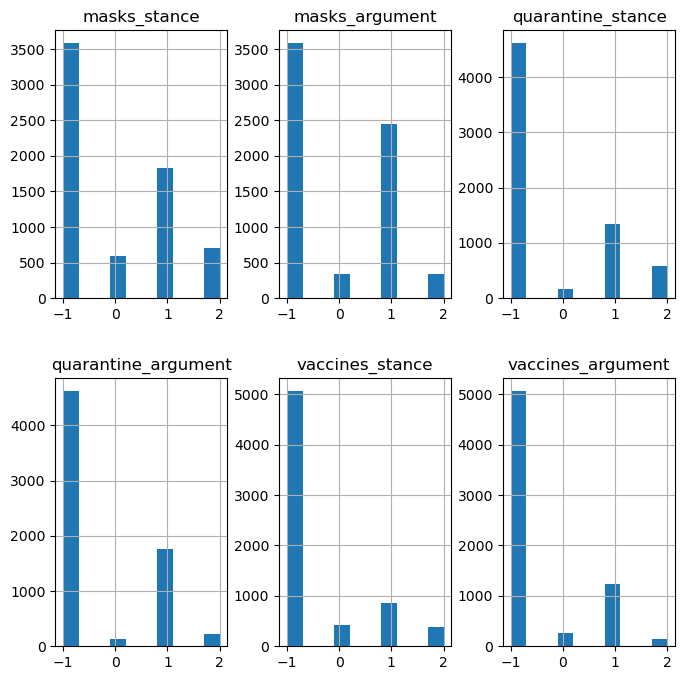

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots(2,3,figsize=(8, 8))
df.drop('text', 1).hist(ax=axis)

**unbalanced as expected**

In [106]:
data_test = []
 
with open("/kaggle/working/test-no_labels.tsv") as f:
    for line in f:
        l = line.replace('\n', '').split('\t')
        data_test.append(l)

In [107]:
df_test = pd.DataFrame(data_test[1:])
df_test.columns = data_test[0]
df_test

,text_id,text,masks_stance,masks_argument,quarantine_stance,quarantine_argument,vaccines_stance,vaccines_argument
0,17059,Каникулы только дадут почву для распостранения...,,,,,,
1,17072,"Думал спокойно посидим в небольшой компании, п...",,,,,,
2,17077,"[USER], в Китае болезнь гуляет с декабря, прос...",,,,,,
3,17082,если переболела бессимптомно добрая треть насе...,,,,,,
4,17089,А подготовка подразумевает собой массовое скоп...,,,,,,
...,...,...,...,...,...,...,...,...
1397,33948,"интересная штука, но лучше точно быть уверенны...",,,,,,
1398,33957,Если все обещанные варианты вакцины в скором в...,,,,,,
1399,33960,"Скоро вакцина от этой заразы станет доступной,...",,,,,,
1400,33993,"Трудности конечно есть, но в конце года каждый...",,,,,,


In [9]:
import pandas as pd
from razdel import tokenize


# Определяем функцию для токенизации текста
def tokenize_text(text):
    tokens = [token.text for token in tokenize(text)]
    return tokens

# Применяем функцию к столбцу 'text' и сохраняем результат в новый столбец 'tokens'
df['tokens'] = df['text'].apply(tokenize_text)

df.head(10)

,text_id,text,masks_stance,masks_argument,quarantine_stance,quarantine_argument,vaccines_stance,vaccines_argument,tokens
0,17024,"[USER], согласно предписаниям Роспотребнадзора...",-1,-1,1,1,-1,-1,"[[, USER, ], ,, согласно, предписаниям, Роспот..."
1,17025,О несоблюдении карантинных мер контактными лиц...,-1,-1,1,1,-1,-1,"[О, несоблюдении, карантинных, мер, контактным..."
2,17027,"[USER], читайте больше книжек на карантине, мо...",-1,-1,1,1,-1,-1,"[[, USER, ], ,, читайте, больше, книжек, на, к..."
3,17030,Иди почитай инсту наших городских пабликов где...,-1,-1,1,1,-1,-1,"[Иди, почитай, инсту, наших, городских, паблик..."
4,17031,"Все контактные лица, которых они обозначили, о...",-1,-1,1,1,-1,-1,"[Все, контактные, лица, ,, которых, они, обозн..."
5,17033,"[USER], многие находятся на домашнем карантине",-1,-1,1,1,-1,-1,"[[, USER, ], ,, многие, находятся, на, домашне..."
6,17034,Если бы сразу запретили перелеты и ввели каран...,-1,-1,2,1,-1,-1,"[Если, бы, сразу, запретили, перелеты, и, ввел..."
7,17036,"[USER], надеемся, что в других регионах не при...",-1,-1,1,1,-1,-1,"[[, USER, ], ,, надеемся, ,, что, в, других, р..."
8,17037,"[USER], почему доктор зойдберг не имеет песню ...",1,1,1,1,-1,-1,"[[, USER, ], ,, почему, доктор, зойдберг, не, ..."
9,17042,"вот из-за таких идиотов, которые ходят без мас...",2,1,2,1,-1,-1,"[вот, из-за, таких, идиотов, ,, которые, ходят..."


In [10]:
df.masks_stance.value_counts()

-1    3587
 1    1832
 2     704
 0     594
Name: masks_stance, dtype: int64

In [15]:
import pandas as pd
from collections import Counter

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('russian')
stop_words = stop_words.append('user')
morph = pymorphy2.MorphAnalyzer()


def lemmatize_word(word):
    return morph.parse(word)[0].normal_form

# Функция для токенизации текста и выбора наиболее частых слов
def get_top_words(text):
    stop_words = stopwords.words('russian')
    count_all = Counter()
    for item in text:
        counter = Counter([lemmatize_word(word) for word in item if word not in stop_words and word.isalpha()])
        count_all.update(counter)
    return count_all

# Применение функции к столбцу 'text' и сохранение результатов в новый столбец 'top_words'
print(len(get_top_words(df['tokens'])))
get_top_words(df['tokens']).most_common(35)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
9974


[('маска', 3408),
 ('карантин', 2021),
 ('user', 1719),
 ('вакцина', 1218),
 ('человек', 963),
 ('это', 836),
 ('который', 525),
 ('носить', 503),
 ('вирус', 500),
 ('а', 380),
 ('быть', 375),
 ('весь', 327),
 ('в', 287),
 ('прививка', 281),
 ('тот', 280),
 ('год', 267),
 ('сидеть', 259),
 ('дом', 246),
 ('такой', 245),
 ('страна', 241),
 ('один', 233),
 ('свой', 233),
 ('вакцинация', 232),
 ('говорить', 231),
 ('работать', 230),
 ('ещё', 229),
 ('сам', 229),
 ('ходить', 226),
 ('день', 221),
 ('делать', 220),
 ('неделя', 218),
 ('аптека', 215),
 ('другой', 214),
 ('мочь', 213),
 ('время', 205)]

**as expected there are many words connected with covid in the dataset**

*I thought about using these words as keywords and to delete some other words as augmentation, but I had not enough time to try it :(*

In [16]:
rare_words = [
    token for token, value in get_top_words(df['tokens']).items()
    if value == 1
]

print(f'number of rare words = {len(rare_words)}, here are some examples of them:')
print(*rare_words[:20])

number of rare words = 5211, here are some examples of them:
транзитный реанимировать обозначить перелёт зойдберг юар привет отдышка постепенный сплотиться бесстрашный одинокий вино сиеста питерский катостпрф заглушить жадность выбить бориться


**There are many rare words form, but I'm not sure if we should get rid of them. Some of them might show a common mood of a sentence. But we might use them in masking augmentation**

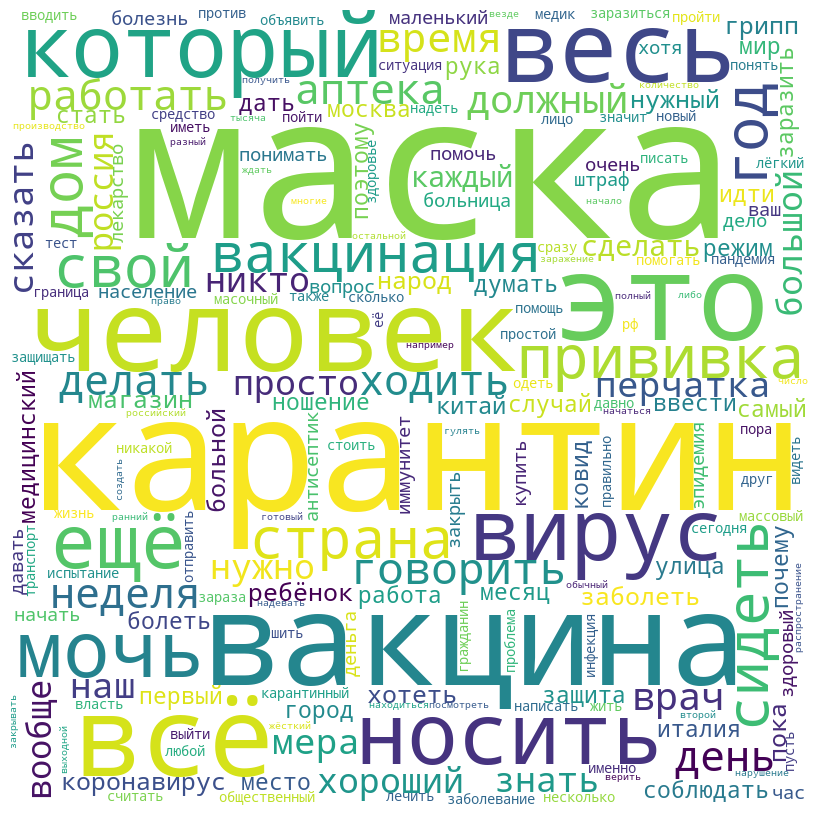

In [54]:
import pandas as pd
from wordcloud import WordCloud
from nltk.corpus import stopwords
import razdel
import pymorphy2


morph = pymorphy2.MorphAnalyzer()

# Создаем список стоп-слов
stop_words = stopwords.words('russian')
stop_words.append('user')
stop_words.append('[')
stop_words.append(']')

def lemmatize_word(word):
    return morph.parse(word)[0].normal_form

def tokenize_and_lemmatize(text):
    tokens = [token.text.lower() for token in razdel.tokenize(text)]
    lemmas = [lemmatize_word(token) for token in tokens]
    return [lemma for lemma in lemmas if lemma not in stop_words and lemma.isalpha()]

# tokenize_and_lemmatize for rows in df.text
df['lemmas'] = df['text'].apply(tokenize_and_lemmatize)

word_freq = {}
for lemmas in df['lemmas']:
    for lemma in lemmas:
        if lemma in word_freq:
            word_freq[lemma] += 1
        else:
            word_freq[lemma] = 1

# wordcloud creating
wordcloud = WordCloud(width=800, height=800, background_color='white', stopwords=stop_words, min_font_size=10).generate_from_frequencies(word_freq)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()


**It doesn't make much sense but looks good**

## 3.4 My method of text processing

Baseline:

- just looking on mbert and rubert-tiny
- use similar hyperparameters for each class

functions for creating datasets:

In [17]:
import numpy as np
from tqdm.auto import tqdm, trange

from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict, load_metric

def create_dataset_from_df(df, label):
    data = Dataset.from_dict({'text': df.text, 'label': df[label]+1}).train_test_split(test_size=0.2, seed=1337)
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
    return data_tokenized['train'], data_tokenized['test'], tokenizer

def create_dataset_from_df_test(df, tokenizer):
    data = Dataset.from_dict({'text': df.text})
    data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
    return data_tokenized


function for training and evaluation:

In [112]:
from transformers import AutoModel, Trainer, TrainingArguments, logging
import evaluate
import gc
import torch

    
def compute_metrics(eval_preds): 
    metric = evaluate.load("f1")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, average='weighted')


def train_eval(base_model, training_args):
    gc.collect()
    torch.cuda.empty_cache()
    logging.set_verbosity_error()
    
    label_list = ['masks_stance', 'masks_argument', 'quarantine_stance',
             'quarantine_argument', 'vaccines_stance', 'vaccines_argument']
    logits_dict = {}
    
    for label in label_list:
            print(label)
            train_dataset, val_dataset, tokenizer = create_dataset_from_df(df, label)

            model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=4)

            #for layer in model.bert.embeddings.parameters(): #  freezing layers of embeddings
             #   layer.requires_grad = False

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=val_dataset,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics
            )
            trainer.train()

            results = trainer.evaluate(val_dataset)
            print(results)
        
            test_dataset = create_dataset_from_df_test(df_test, tokenizer)
            preds = trainer.predict(test_dataset)
            logits_dict[label] = preds.predictions
            ans = np.argmax(preds.predictions, axis = -1)
            df_test[label] = ans - 1
            
    return logits_dict

In [19]:
base_model = 'DeepPavlov/rubert-base-cased-conversational'

training_args = TrainingArguments(
                output_dir="./results",
                evaluation_strategy="epoch",
                learning_rate=1e-5,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                num_train_epochs=5,
                weight_decay=0.01,
                push_to_hub=False,
                logging_dir="./logs",
                logging_steps=500,
                metric_for_best_model="accuracy",
                greater_is_better=True,
            )

logit_dict_dp = train_eval(base_model, training_args) 

masks_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: Currently logged in as: eksolodneva. Use `wandb login --relogin` to force relogin


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Epoch,Training Loss,Validation Loss,F1
1,0.588000,0.411745,0.815948
2,0.368300,0.447030,0.822379
3,0.216600,0.594675,0.828082
4,0.121400,0.725842,0.822978
5,0.107400,0.795734,0.823713


{'eval_loss': 0.7957336902618408, 'eval_f1': 0.8237125224623971, 'eval_runtime': 3.6911, 'eval_samples_per_second': 364.121, 'eval_steps_per_second': 45.515, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?ba/s]

masks_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.472400,0.285755,0.890960
2,0.269800,0.290101,0.885212
3,0.155200,0.362690,0.904247
4,0.101300,0.421074,0.914585
5,0.067800,0.459510,0.912434


{'eval_loss': 0.45951026678085327, 'eval_f1': 0.9124341656119809, 'eval_runtime': 3.7379, 'eval_samples_per_second': 359.562, 'eval_steps_per_second': 44.945, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?ba/s]

quarantine_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.448300,0.302260,0.846838
2,0.285200,0.253843,0.896326
3,0.225200,0.317720,0.902637
4,0.168400,0.389064,0.898938
5,0.130300,0.393563,0.904466


{'eval_loss': 0.3935633599758148, 'eval_f1': 0.9044661573385188, 'eval_runtime': 3.7355, 'eval_samples_per_second': 359.795, 'eval_steps_per_second': 44.974, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?ba/s]

quarantine_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.367300,0.227392,0.919125
2,0.209700,0.207737,0.929136
3,0.151900,0.225223,0.936014
4,0.116500,0.242192,0.937911
5,0.082400,0.264414,0.937817


{'eval_loss': 0.2644138038158417, 'eval_f1': 0.9378174065093114, 'eval_runtime': 3.7836, 'eval_samples_per_second': 355.216, 'eval_steps_per_second': 44.402, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?ba/s]

vaccines_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.395700,0.262490,0.837484
2,0.270500,0.282551,0.837484
3,0.211900,0.272110,0.902572
4,0.134400,0.339654,0.904554
5,0.094300,0.380101,0.906659


{'eval_loss': 0.38010096549987793, 'eval_f1': 0.9066587271077732, 'eval_runtime': 3.7516, 'eval_samples_per_second': 358.249, 'eval_steps_per_second': 44.781, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?ba/s]

vaccines_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch,Training Loss,Validation Loss,F1
1,0.338000,0.182358,0.914982
2,0.199600,0.188136,0.927698
3,0.167100,0.224951,0.929761
4,0.094500,0.224450,0.933724
5,0.074600,0.226313,0.936235


{'eval_loss': 0.22631345689296722, 'eval_f1': 0.9362350899617982, 'eval_runtime': 3.9947, 'eval_samples_per_second': 336.445, 'eval_steps_per_second': 42.056, 'epoch': 5.0}


  0%|          | 0/2 [00:00<?, ?ba/s]

In [42]:
import pickle 

with open('deepp_logits.pkl', 'wb') as f:
    pickle.dump(logit_dict_dp, f)
        
#with open('deepp_logits.pkl', 'rb') as f:
 #   logit_dict_dp = pickle.load(f)

array([[<AxesSubplot:title={'center':'masks_stance'}>,
        <AxesSubplot:title={'center':'masks_argument'}>,
        <AxesSubplot:title={'center':'quarantine_stance'}>],
       [<AxesSubplot:title={'center':'quarantine_argument'}>,
        <AxesSubplot:title={'center':'vaccines_stance'}>,
        <AxesSubplot:title={'center':'vaccines_argument'}>]], dtype=object)

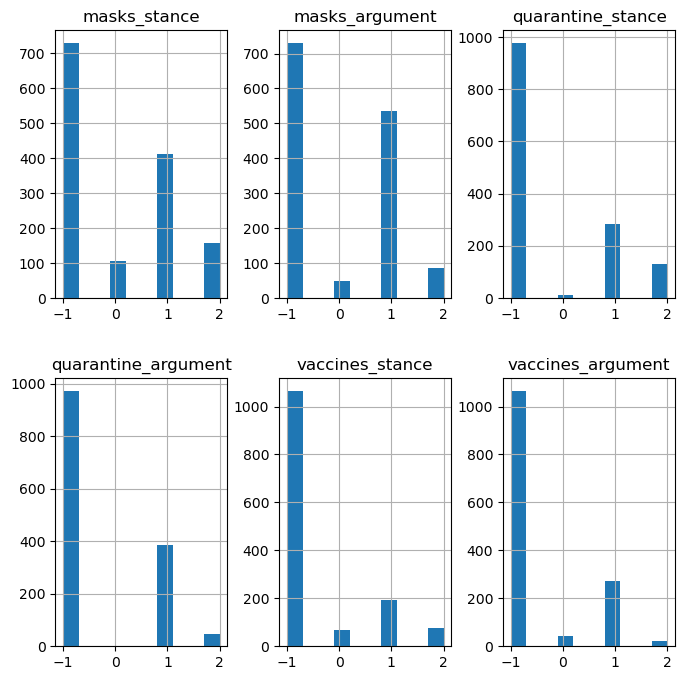

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots(2,3,figsize=(8, 8))
df_test.hist(ax=axis)

**lets freeze embeddings layers and do the same but with mbert**

In [22]:
base_model = "bert-base-multilingual-cased"

training_args = TrainingArguments(
                output_dir="./results",
                evaluation_strategy="epoch",
                learning_rate=1e-5,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                num_train_epochs=5,
                weight_decay=0.01,
                push_to_hub=False,
                logging_dir="./logs",
                logging_steps=500,
                metric_for_best_model="accuracy",
                greater_is_better=True,
            )

logit_dict_mb = train_eval(base_model, training_args) 

masks_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.6133, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.4570165276527405, 'eval_f1': 0.7337640490979, 'eval_runtime': 4.9107, 'eval_samples_per_second': 273.686, 'eval_steps_per_second': 34.211, 'epoch': 1.0}
{'loss': 0.4502, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.4662817120552063, 'eval_f1': 0.7560949975919082, 'eval_runtime': 4.9162, 'eval_samples_per_second': 273.383, 'eval_steps_per_second': 34.173, 'epoch': 2.0}
{'loss': 0.4266, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.3845, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.47059985995292664, 'eval_f1': 0.803169382290041, 'eval_runtime': 4.9086, 'eval_samples_per_second': 273.808, 'eval_steps_per_second': 34.226, 'epoch': 3.0}
{'loss': 0.3462, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.5502662062644958, 'eval_f1': 0.7956959205763686, 'eval_runtime': 4.8938, 'eval_samples_per_second': 274.636, '

  0%|          | 0/2 [00:00<?, ?ba/s]

masks_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.4309, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.2972358167171478, 'eval_f1': 0.8804005098041463, 'eval_runtime': 4.9254, 'eval_samples_per_second': 272.873, 'eval_steps_per_second': 34.109, 'epoch': 1.0}
{'loss': 0.2934, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.29155734181404114, 'eval_f1': 0.8785868181142485, 'eval_runtime': 5.083, 'eval_samples_per_second': 264.411, 'eval_steps_per_second': 33.051, 'epoch': 2.0}
{'loss': 0.2728, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.2268, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.33327388763427734, 'eval_f1': 0.8948610804544502, 'eval_runtime': 4.9833, 'eval_samples_per_second': 269.703, 'eval_steps_per_second': 33.713, 'epoch': 3.0}
{'loss': 0.1902, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.3703916370868683, 'eval_f1': 0.8979119665416267, 'eval_runtime': 4.9312, 'eval_samples_per_second': 272.55

  0%|          | 0/2 [00:00<?, ?ba/s]

quarantine_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3906, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.3125229477882385, 'eval_f1': 0.8446406753259706, 'eval_runtime': 4.9607, 'eval_samples_per_second': 270.931, 'eval_steps_per_second': 33.866, 'epoch': 1.0}
{'loss': 0.2999, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.2720130681991577, 'eval_f1': 0.8923438629862972, 'eval_runtime': 4.9203, 'eval_samples_per_second': 273.153, 'eval_steps_per_second': 34.144, 'epoch': 2.0}
{'loss': 0.2699, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.2649, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.3523300886154175, 'eval_f1': 0.8893422172636621, 'eval_runtime': 4.9367, 'eval_samples_per_second': 272.244, 'eval_steps_per_second': 34.03, 'epoch': 3.0}
{'loss': 0.2345, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.409666508436203, 'eval_f1': 0.8923888112873978, 'eval_runtime': 4.9768, 'eval_samples_per_second': 270.055, 

  0%|          | 0/2 [00:00<?, ?ba/s]

quarantine_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3075, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.2454868108034134, 'eval_f1': 0.919611322663035, 'eval_runtime': 5.1806, 'eval_samples_per_second': 259.429, 'eval_steps_per_second': 32.429, 'epoch': 1.0}
{'loss': 0.2245, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.2143907994031906, 'eval_f1': 0.9197377128771718, 'eval_runtime': 4.9485, 'eval_samples_per_second': 271.599, 'eval_steps_per_second': 33.95, 'epoch': 2.0}
{'loss': 0.2119, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.1964, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.23602430522441864, 'eval_f1': 0.9312714167607554, 'eval_runtime': 5.0423, 'eval_samples_per_second': 266.548, 'eval_steps_per_second': 33.318, 'epoch': 3.0}
{'loss': 0.1597, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.24994777143001556, 'eval_f1': 0.9323760882328684, 'eval_runtime': 4.9311, 'eval_samples_per_second': 272.556

  0%|          | 0/2 [00:00<?, ?ba/s]

vaccines_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3642, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.2733147442340851, 'eval_f1': 0.8348103653916102, 'eval_runtime': 4.9187, 'eval_samples_per_second': 273.245, 'eval_steps_per_second': 34.156, 'epoch': 1.0}
{'loss': 0.2739, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.31237292289733887, 'eval_f1': 0.834975368265561, 'eval_runtime': 4.9485, 'eval_samples_per_second': 271.596, 'eval_steps_per_second': 33.949, 'epoch': 2.0}
{'loss': 0.2508, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.2311, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.3233669698238373, 'eval_f1': 0.8727318548387097, 'eval_runtime': 4.9455, 'eval_samples_per_second': 271.762, 'eval_steps_per_second': 33.97, 'epoch': 3.0}
{'loss': 0.1701, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.3952227234840393, 'eval_f1': 0.8753180568817472, 'eval_runtime': 4.9591, 'eval_samples_per_second': 271.018,

  0%|          | 0/2 [00:00<?, ?ba/s]

vaccines_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3086, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.1940527856349945, 'eval_f1': 0.9128516178070039, 'eval_runtime': 5.1554, 'eval_samples_per_second': 260.698, 'eval_steps_per_second': 32.587, 'epoch': 1.0}
{'loss': 0.212, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.20714382827281952, 'eval_f1': 0.91924925934052, 'eval_runtime': 4.9401, 'eval_samples_per_second': 272.061, 'eval_steps_per_second': 34.008, 'epoch': 2.0}
{'loss': 0.1883, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.2081, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.20748665928840637, 'eval_f1': 0.9212657504320677, 'eval_runtime': 6.1249, 'eval_samples_per_second': 219.431, 'eval_steps_per_second': 27.429, 'epoch': 3.0}
{'loss': 0.151, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.20963260531425476, 'eval_f1': 0.9251033933283611, 'eval_runtime': 5.0383, 'eval_samples_per_second': 266.756,

  0%|          | 0/2 [00:00<?, ?ba/s]

**mbert but without freezing embeddings layers**

In [58]:
base_model = "bert-base-multilingual-cased"

training_args = TrainingArguments(
                output_dir="./results",
                evaluation_strategy="epoch",
                learning_rate=1e-5,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                num_train_epochs=5,
                weight_decay=0.01,
                push_to_hub=False,
                logging_dir="./logs",
                logging_steps=500,
                metric_for_best_model="accuracy",
                greater_is_better=True,
            )

logit_dict_mb = train_eval(base_model, training_args) 

masks_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.5865, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.43733614683151245, 'eval_f1': 0.7945490649314567, 'eval_runtime': 4.9393, 'eval_samples_per_second': 272.102, 'eval_steps_per_second': 34.013, 'epoch': 1.0}
{'loss': 0.4191, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.45595842599868774, 'eval_f1': 0.7941900266957591, 'eval_runtime': 4.9827, 'eval_samples_per_second': 269.734, 'eval_steps_per_second': 33.717, 'epoch': 2.0}
{'loss': 0.4033, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.3457, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.482747882604599, 'eval_f1': 0.817350542437618, 'eval_runtime': 4.9712, 'eval_samples_per_second': 270.355, 'eval_steps_per_second': 33.794, 'epoch': 3.0}
{'loss': 0.2874, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.5754931569099426, 'eval_f1': 0.8080997280873002, 'eval_runtime': 4.9512, 'eval_samples_per_second': 271.448

  0%|          | 0/2 [00:00<?, ?ba/s]

masks_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.4308, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.3260844349861145, 'eval_f1': 0.8653712982338129, 'eval_runtime': 5.0069, 'eval_samples_per_second': 268.43, 'eval_steps_per_second': 33.554, 'epoch': 1.0}
{'loss': 0.3005, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.29308438301086426, 'eval_f1': 0.8828130298939311, 'eval_runtime': 4.9714, 'eval_samples_per_second': 270.344, 'eval_steps_per_second': 33.793, 'epoch': 2.0}
{'loss': 0.2745, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.221, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.3511327803134918, 'eval_f1': 0.8932297427657648, 'eval_runtime': 4.9985, 'eval_samples_per_second': 268.881, 'eval_steps_per_second': 33.61, 'epoch': 3.0}
{'loss': 0.1837, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.41779232025146484, 'eval_f1': 0.893381759178313, 'eval_runtime': 4.9517, 'eval_samples_per_second': 271.421, 

  0%|          | 0/2 [00:00<?, ?ba/s]

quarantine_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3888, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.3044807016849518, 'eval_f1': 0.8452468156422979, 'eval_runtime': 4.9613, 'eval_samples_per_second': 270.897, 'eval_steps_per_second': 33.862, 'epoch': 1.0}
{'loss': 0.299, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.27748170495033264, 'eval_f1': 0.8966061756100357, 'eval_runtime': 5.0475, 'eval_samples_per_second': 266.269, 'eval_steps_per_second': 33.284, 'epoch': 2.0}
{'loss': 0.2677, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.261, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.3637670874595642, 'eval_f1': 0.8877557976087639, 'eval_runtime': 5.0065, 'eval_samples_per_second': 268.45, 'eval_steps_per_second': 33.556, 'epoch': 3.0}
{'loss': 0.2187, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.415452778339386, 'eval_f1': 0.8901531078064457, 'eval_runtime': 4.9913, 'eval_samples_per_second': 269.266, '

  0%|          | 0/2 [00:00<?, ?ba/s]

quarantine_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3078, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.24742144346237183, 'eval_f1': 0.919611322663035, 'eval_runtime': 4.965, 'eval_samples_per_second': 270.696, 'eval_steps_per_second': 33.837, 'epoch': 1.0}
{'loss': 0.2221, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.21800653636455536, 'eval_f1': 0.9221301049738114, 'eval_runtime': 5.0485, 'eval_samples_per_second': 266.22, 'eval_steps_per_second': 33.278, 'epoch': 2.0}
{'loss': 0.2111, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.1885, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.24222955107688904, 'eval_f1': 0.9289491417981172, 'eval_runtime': 5.1025, 'eval_samples_per_second': 263.402, 'eval_steps_per_second': 32.925, 'epoch': 3.0}
{'loss': 0.1563, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.25885695219039917, 'eval_f1': 0.926230363963712, 'eval_runtime': 5.0702, 'eval_samples_per_second': 265.076

  0%|          | 0/2 [00:00<?, ?ba/s]

vaccines_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3669, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.2778872847557068, 'eval_f1': 0.834975368265561, 'eval_runtime': 4.9548, 'eval_samples_per_second': 271.25, 'eval_steps_per_second': 33.906, 'epoch': 1.0}
{'loss': 0.2772, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.3108009099960327, 'eval_f1': 0.8355204509652671, 'eval_runtime': 5.0121, 'eval_samples_per_second': 268.152, 'eval_steps_per_second': 33.519, 'epoch': 2.0}
{'loss': 0.2542, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.2374, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.3082664906978607, 'eval_f1': 0.8686364450801014, 'eval_runtime': 5.0559, 'eval_samples_per_second': 265.83, 'eval_steps_per_second': 33.229, 'epoch': 3.0}
{'loss': 0.1811, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.36869195103645325, 'eval_f1': 0.8891799932753864, 'eval_runtime': 4.9655, 'eval_samples_per_second': 270.668, 

  0%|          | 0/2 [00:00<?, ?ba/s]

vaccines_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3089, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
{'eval_loss': 0.196701318025589, 'eval_f1': 0.9128516178070039, 'eval_runtime': 4.9526, 'eval_samples_per_second': 271.37, 'eval_steps_per_second': 33.921, 'epoch': 1.0}
{'loss': 0.2152, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
{'eval_loss': 0.19234775006771088, 'eval_f1': 0.9214045278780193, 'eval_runtime': 4.968, 'eval_samples_per_second': 270.53, 'eval_steps_per_second': 33.816, 'epoch': 2.0}
{'loss': 0.1888, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.1976, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.22103586792945862, 'eval_f1': 0.9188121206221644, 'eval_runtime': 5.0382, 'eval_samples_per_second': 266.762, 'eval_steps_per_second': 33.345, 'epoch': 3.0}
{'loss': 0.1441, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
{'eval_loss': 0.23423337936401367, 'eval_f1': 0.9267872372664964, 'eval_runtime': 4.9568, 'eval_samples_per_second': 271.143,

  0%|          | 0/2 [00:00<?, ?ba/s]

**gives almost same result on codalab :(**

In [59]:
df_test.to_csv('sub_mbert_new.tsv', sep='\t', index=False)

array([[<AxesSubplot:title={'center':'masks_stance'}>,
        <AxesSubplot:title={'center':'masks_argument'}>,
        <AxesSubplot:title={'center':'quarantine_stance'}>],
       [<AxesSubplot:title={'center':'quarantine_argument'}>,
        <AxesSubplot:title={'center':'vaccines_stance'}>,
        <AxesSubplot:title={'center':'vaccines_argument'}>]], dtype=object)

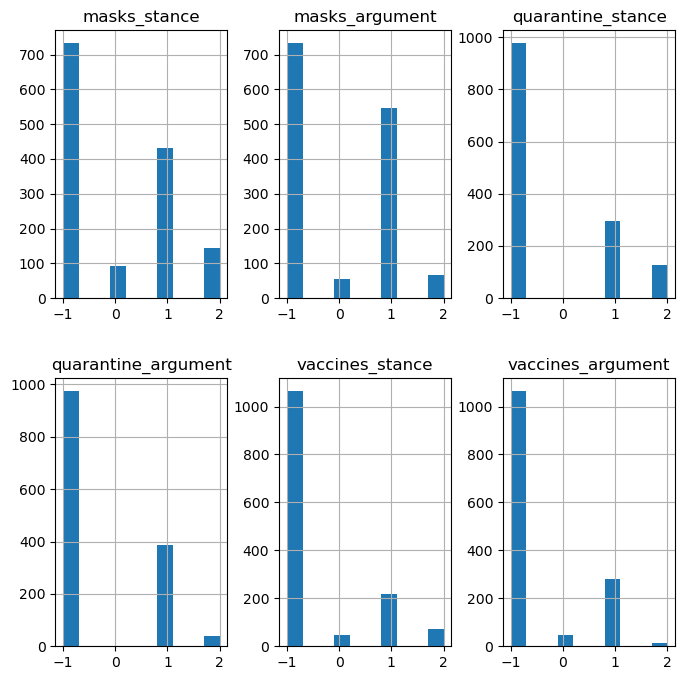

In [52]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axis = plt.subplots(2,3,figsize=(8, 8))
df_test.hist(ax=axis)

Lets' try a kind of ansamble

In [51]:
label_list = ['masks_stance', 'masks_argument', 'quarantine_stance',
             'quarantine_argument', 'vaccines_stance', 'vaccines_argument']

df_test_new = df_test
for label in label_list:
    logits_1 = logit_dict_dp[label]
    logits_2 = logit_dict_mb[label]
    logits_cur = (logits_2 + logits_1) / 2
    df_test_new[label] = np.argmax(logits_cur, axis = -1) - 1

In [53]:
df_test_new.to_csv('sub_ans1.tsv', sep='\t', index=False)

**Lets try to give rubert model not initial sentences but lemmas**

using fucntion from preprocessing on test dataset:

In [86]:
df_test['lemmas'] = df_test['text'].apply(tokenize_and_lemmatize)

rewritten functions for creating datasets:

In [81]:
def create_dataset_from_df(df, label):
    data = Dataset.from_dict({'lemmas': df.lemmas.apply(' '.join), 'label': df[label]+1}).train_test_split(test_size=0.2, seed=1337)
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    data_tokenized = data.map(lambda x: tokenizer(x['lemmas'], truncation=True, max_length=512), batched=True, remove_columns=['lemmas'])
    return data_tokenized['train'], data_tokenized['test'], tokenizer

def create_dataset_from_df_test(df, tokenizer):
    data = Dataset.from_dict({'lemmas': df.lemmas.apply(' '.join)})
    data_tokenized = data.map(lambda x: tokenizer(x['lemmas'], truncation=True, max_length=512), batched=True, remove_columns=['lemmas'])
    return data_tokenized


In [74]:
df.lemmas.apply(' '.join)

0       согласно предписание роспотребнадзор всё транз...
1       несоблюдение карантинный мера контактный лицо ...
2       читать большой книжка карантин мочь мозг реани...
3       идти почитай инст наш городской пабликовый каж...
4       всё контактный лицо который обозначить отправи...
                              ...                        
6712    большой заботить врач который вынудить запаков...
6713               жрать жрать вирус народ вакцина прийти
6714       вопрос волновать ещё убить вакцина кроме ковид
6715    говорить российский медицина заразить маленьки...
6716    вакцина предотвращать заболевание просто помог...
Name: lemmas, Length: 6717, dtype: object

In [89]:
base_model = 'DeepPavlov/rubert-base-cased-conversational'

training_args = TrainingArguments(
                output_dir="./results",
                evaluation_strategy="epoch",
                learning_rate=1e-5,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                num_train_epochs=5,
                weight_decay=0.01,
                push_to_hub=False,
                logging_dir="./logs",
                logging_steps=500,
                metric_for_best_model="accuracy",
                greater_is_better=True,
            )

logit_dict_dp = train_eval(base_model, training_args) 

masks_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.5649, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}
F1 = {'f1': 0.7875565129787399}, precision = {'precision': 0.7852362738570585}, recall = {'recall': 0.8125}
{'eval_loss': 0.4245387613773346, 'eval_f1': 0.7875565129787399, 'eval_runtime': 3.4839, 'eval_samples_per_second': 385.775, 'eval_steps_per_second': 48.222, 'epoch': 1.0}
{'loss': 0.4047, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
F1 = {'f1': 0.7932724491703104}, precision = {'precision': 0.8252709789985287}, recall = {'recall': 0.8013392857142857}
{'eval_loss': 0.45407214760780334, 'eval_f1': 0.7932724491703104, 'eval_runtime': 3.4791, 'eval_samples_per_second': 386.312, 'eval_steps_per_second': 48.289, 'epoch': 2.0}
{'loss': 0.3818, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.3057, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
F1 = {'f1': 0.8134184846765473}, precision = {'precision': 0.8145790386678868}, recall = {'recall': 0.8132440476190477}
{'eval_loss': 0.517

  0%|          | 0/2 [00:00<?, ?ba/s]

masks_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.4173, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.8796637746872416}, precision = {'precision': 0.8660347319252735}, recall = {'recall': 0.8958333333333334}
{'eval_loss': 0.29406678676605225, 'eval_f1': 0.8796637746872416, 'eval_runtime': 3.5047, 'eval_samples_per_second': 383.486, 'eval_steps_per_second': 47.936, 'epoch': 1.0}
{'loss': 0.2942, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
F1 = {'f1': 0.8944166370035237}, precision = {'precision': 0.8908269722634956}, recall = {'recall': 0.8988095238095238}
{'eval_loss': 0.3085186183452606, 'eval_f1': 0.8944166370035237, 'eval_runtime': 3.4431, 'eval_samples_per_second': 390.345, 'eval_steps_per_second': 48.793, 'epoch': 2.0}
{'loss': 0.2673, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.2342, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
F1 = {'f1': 0.8931139189181853}, precision = {'precision': 0.8891263162324257}, recall = {'recall': 0.9047619047619048}
{'eval_loss': 0.3204443156719208, 'eval_f1': 0.8931139189181853, 'eval_runtime'

  0%|          | 0/2 [00:00<?, ?ba/s]

quarantine_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.425, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.8474437977402164}, precision = {'precision': 0.8180098895861764}, recall = {'recall': 0.890625}
{'eval_loss': 0.30342382192611694, 'eval_f1': 0.8474437977402164, 'eval_runtime': 3.3202, 'eval_samples_per_second': 404.8, 'eval_steps_per_second': 50.6, 'epoch': 1.0}
{'loss': 0.2942, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.8891705108736832}, precision = {'precision': 0.8802360138562332}, recall = {'recall': 0.8988095238095238}
{'eval_loss': 0.27907320857048035, 'eval_f1': 0.8891705108736832, 'eval_runtime': 3.4695, 'eval_samples_per_second': 387.373, 'eval_steps_per_second': 48.422, 'epoch': 2.0}
{'loss': 0.2624, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.2604, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.8952131687357}, precision = {'precision': 0.8880995394193344}, recall = {'recall': 0.9040178571428571}
{'eval_loss': 0.3585052490234375, 'eval_f1': 0.8952131687357, 'eval_runtime': 3.4435, 'eval_samples_per_second': 390.298, 'eval_steps_per_second': 48.787, 'epoch': 3.0}
{'loss': 0.2178, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.8900332727795972}, precision = {'precision': 0.8803274306440682}, recall = {'recall': 0.9025297619047619}
{'eval_loss': 0.40305382013320923, 'eval_f1': 0.8900332727795972, 'eval_runtime': 3.3416, 'eval_samples_per_second': 402.202, 'eval_steps_per_second': 50.275, 'epoch': 4.0}
{'loss': 0.171, 'learning_rate': 1.0714285714285714e-06, 'epoch': 4.46}
F1 = {'f1': 0.8941973956720378}, precision = {'precision': 0.8850630200018637}, recall = {'recall': 0.9040178571428571}
{'eval_loss': 0.411275714635849, 'eval_f1': 0.8941973956720378, 'eval_runtime': 3.5248, 'eval_samples_per_second': 381.294, 'eval_steps_per_second': 47.662, 'epoch': 5.0}
{'train_runtime': 317.2074, 'train_samples_per_second': 84.692, 'train_steps_per_second': 10.592, 'train_loss': 0.2623223145802816, 'epoch': 5.0}
F1 = {'f1': 0.8941973956720378}, precision = {'precision': 0.8850630200018637}, recall = {'recall': 0.9040178571428571}
{'eval_loss': 0.411275714635849, 'eval_f1': 0.8941973956720378, 'eval_runtime'

  0%|          | 0/2 [00:00<?, ?ba/s]

quarantine_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3333, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.9184461358994976}, precision = {'precision': 0.8990935680727768}, recall = {'recall': 0.9412202380952381}
{'eval_loss': 0.21436592936515808, 'eval_f1': 0.9184461358994976, 'eval_runtime': 3.6462, 'eval_samples_per_second': 368.607, 'eval_steps_per_second': 46.076, 'epoch': 1.0}
{'loss': 0.2146, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.9251943402414009}, precision = {'precision': 0.9206351234523508}, recall = {'recall': 0.9419642857142857}
{'eval_loss': 0.2430759221315384, 'eval_f1': 0.9251943402414009, 'eval_runtime': 3.589, 'eval_samples_per_second': 374.476, 'eval_steps_per_second': 46.809, 'epoch': 2.0}
{'loss': 0.2023, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.1675, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.9341803784443766}, precision = {'precision': 0.9275492694433555}, recall = {'recall': 0.9412202380952381}
{'eval_loss': 0.24237433075904846, 'eval_f1': 0.9341803784443766, 'eval_runtime': 3.784, 'eval_samples_per_second': 355.183, 'eval_steps_per_second': 44.398, 'epoch': 3.0}
{'loss': 0.1439, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.9373777215798985}, precision = {'precision': 0.929557589965856}, recall = {'recall': 0.9456845238095238}
{'eval_loss': 0.25296884775161743, 'eval_f1': 0.9373777215798985, 'eval_runtime': 3.372, 'eval_samples_per_second': 398.573, 'eval_steps_per_second': 49.822, 'epoch': 4.0}
{'loss': 0.1182, 'learning_rate': 1.0714285714285714e-06, 'epoch': 4.46}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.9340072527027123}, precision = {'precision': 0.9264158806701714}, recall = {'recall': 0.9419642857142857}
{'eval_loss': 0.27902036905288696, 'eval_f1': 0.9340072527027123, 'eval_runtime': 3.3943, 'eval_samples_per_second': 395.954, 'eval_steps_per_second': 49.494, 'epoch': 5.0}
{'train_runtime': 306.7016, 'train_samples_per_second': 87.593, 'train_steps_per_second': 10.955, 'train_loss': 0.18787271181742352, 'epoch': 5.0}
F1 = {'f1': 0.9340072527027123}, precision = {'precision': 0.9264158806701714}, recall = {'recall': 0.9419642857142857}
{'eval_loss': 0.27902036905288696, 'eval_f1': 0.9340072527027123, 'eval_runtime': 3.3573, 'eval_samples_per_second': 400.326, 'eval_steps_per_second': 50.041, 'epoch': 5.0}
{'eval_loss': 0.27902036905288696, 'eval_f1': 0.9340072527027123, 'eval_runtime': 3.3573, 'eval_samples_per_second': 400.326, 'eval_steps_per_second': 50.041, 'epoch': 5.0}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


  0%|          | 0/2 [00:00<?, ?ba/s]

vaccines_stance


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3662, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.8381913563090606}, precision = {'precision': 0.8167001267962807}, recall = {'recall': 0.8794642857142857}
{'eval_loss': 0.26868635416030884, 'eval_f1': 0.8381913563090606, 'eval_runtime': 3.3541, 'eval_samples_per_second': 400.708, 'eval_steps_per_second': 50.088, 'epoch': 1.0}
{'loss': 0.2627, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}
F1 = {'f1': 0.8575166306297717}, precision = {'precision': 0.8897409899438667}, recall = {'recall': 0.8846726190476191}
{'eval_loss': 0.27947187423706055, 'eval_f1': 0.8575166306297717, 'eval_runtime': 3.427, 'eval_samples_per_second': 392.175, 'eval_steps_per_second': 49.022, 'epoch': 2.0}
{'loss': 0.2271, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.2129, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
F1 = {'f1': 0.888483534231485}, precision = {'precision': 0.8907294176420792}, recall = {'recall': 0.8891369047619048}
{'eval_loss': 0.29455119371414185, 'eval_f1': 0.888483534231485, 'eval_runtime':

  0%|          | 0/2 [00:00<?, ?ba/s]

vaccines_argument


  0%|          | 0/6 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3018, 'learning_rate': 8.511904761904762e-06, 'epoch': 0.74}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.9150676502500303}, precision = {'precision': 0.8957433452732124}, recall = {'recall': 0.9404761904761905}
{'eval_loss': 0.16596801578998566, 'eval_f1': 0.9150676502500303, 'eval_runtime': 3.62, 'eval_samples_per_second': 371.267, 'eval_steps_per_second': 46.408, 'epoch': 1.0}
{'loss': 0.1913, 'learning_rate': 7.023809523809524e-06, 'epoch': 1.49}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.9238987284829395}, precision = {'precision': 0.9185429534156853}, recall = {'recall': 0.9300595238095238}
{'eval_loss': 0.20378564298152924, 'eval_f1': 0.9238987284829395, 'eval_runtime': 3.402, 'eval_samples_per_second': 395.066, 'eval_steps_per_second': 49.383, 'epoch': 2.0}
{'loss': 0.162, 'learning_rate': 5.535714285714286e-06, 'epoch': 2.23}
{'loss': 0.1715, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 = {'f1': 0.9329678357883244}, precision = {'precision': 0.9256469896875947}, recall = {'recall': 0.9471726190476191}
{'eval_loss': 0.21703220903873444, 'eval_f1': 0.9329678357883244, 'eval_runtime': 3.3752, 'eval_samples_per_second': 398.201, 'eval_steps_per_second': 49.775, 'epoch': 3.0}
{'loss': 0.1229, 'learning_rate': 2.5595238095238095e-06, 'epoch': 3.72}
F1 = {'f1': 0.9344861748527161}, precision = {'precision': 0.9321141098484848}, recall = {'recall': 0.9389880952380952}
{'eval_loss': 0.2216402292251587, 'eval_f1': 0.9344861748527161, 'eval_runtime': 3.3711, 'eval_samples_per_second': 398.686, 'eval_steps_per_second': 49.836, 'epoch': 4.0}
{'loss': 0.0957, 'learning_rate': 1.0714285714285714e-06, 'epoch': 4.46}
F1 = {'f1': 0.932430442769548}, precision = {'precision': 0.9314474473075747}, recall = {'recall': 0.9345238095238095}
{'eval_loss': 0.2363705188035965, 'eval_f1': 0.932430442769548, 'eval_runtime': 3.3692, 'eval_samples_per_second': 398.911, 'eval_steps_per_second': 4

  0%|          | 0/2 [00:00<?, ?ba/s]

In [129]:
df_test.to_csv('sub_dp_lemmas.tsv', sep='\t', index=False)

**As we see in f1_eval score became worse. May be there are many semantic shades in sentences that show mood of its author**

**I think it's good idea to make some data augmentation with paraphraser**

Let's try to add similar phrases to dataset and make it twice as big

In [102]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
MODEL_NAME = 'cointegrated/rut5-base-paraphraser'
model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
model.cuda()
model.eval();

In [103]:
def paraphrase(text, beams=4, grams=2, do_sample=False):
    x = tokenizer(text, return_tensors='pt', padding=True).to(model.device)
    max_size = int(x.input_ids.shape[1] * 1.5 + 10)
    out = model.generate(**x, encoder_no_repeat_ngram_size=grams, num_beams=beams, max_length=max_size, do_sample=do_sample)
    return tokenizer.decode(out[0], skip_special_tokens=True)

print(df.text[2])
print(paraphrase(df.text[2]))
print(df.text[1])
print(paraphrase(df.text[1]))

[USER], читайте больше книжек на карантине, может мозг реанимируете
Если вы читаете больше книг на коронавирусе - значит, вы будете более уверены в своем мозге
О несоблюдении карантинных мер контактными лицами можно сообщить на на горячую линию Роспотребнадзора - 8-800-100-0004 (можно позвонить бесплатно из любого населенного пункта России в рабочие дни с 10-00 до 17-00 (время московское), перерыв с 12-00 до 12-45) или в Единый консультационный центр Роспотребнадзора - 8-800-555-49-43.
Контактные лица могут сообщать о невыполнении мер по борьбе с коронавирусом по телефону: +7 (800) 100 0004 (бесплатно звонить из любое населенное лицо России с 10 до 17 часов (московский час), с 12 до 15 часов) и в единый центр консультирования по телефону: +7 (800) 555 49 43 (800) 555 49 43 (800) 555 49 43).


grams = 2 - is enough to get another sentences which are not very close to original

beams = 4 - to make it works a little bit faster, (beams = 3 is faster but we will get too similar sentences)

In [ ]:
df_new = df
df_new['text'] = df['text'].apply(paraphrase)

**Okay, this is not good idea to do in two hours before deadline, it works very slow 🤥**

**Better we will try to improve my leaderboard score with simple idea:**

- Use the best model on the whole train dataset and exclude numbers and stop words from it (I've forgot to make it earlier)

In [118]:
from razdel import tokenize

stop_words = stopwords.words('russian')
stop_words.append('USER')
stop_words.append('[')
stop_words.append(']')

def tokenize_text(text):
    tokens = [token.text for token in tokenize(text)]
    return ' '.join([token for token in tokens if not token in stop_words and token.isalpha()])

df.text = df.text.apply(tokenize_text)
df_test.text = df_test.text.apply(tokenize_text)

In [ ]:
def create_dataset_from_df(df, label):
    data = Dataset.from_dict({'text': df.text, 'label': df[label]+1})
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
    return data_tokenized, tokenizer

def create_dataset_from_df_test(df, tokenizer):
    data = Dataset.from_dict({'text': df.text})
    data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
    return data_tokenized

In [127]:
def train_eval(base_model, training_args):
    gc.collect()
    torch.cuda.empty_cache()
    logging.set_verbosity_error()
    
    label_list = ['masks_stance', 'masks_argument', 'quarantine_stance',
             'quarantine_argument', 'vaccines_stance', 'vaccines_argument']
    logits_dict = {}
    
    for label in label_list:
            print(label)
            train_dataset, tokenizer = create_dataset_from_df(df, label)

            model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=4)

            #for layer in model.bert.embeddings.parameters(): #  freezing layers of embeddings
             #   layer.requires_grad = False

            trainer = Trainer(
                model=model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=train_dataset,
                tokenizer=tokenizer,
                compute_metrics=compute_metrics
            )
            trainer.train()
        
            test_dataset = create_dataset_from_df_test(df_test, tokenizer)
            preds = trainer.predict(test_dataset)
            logits_dict[label] = preds.predictions
            ans = np.argmax(preds.predictions, axis = -1)
            df_test[label] = ans - 1
            
    return logits_dict

In [128]:
base_model = 'DeepPavlov/rubert-base-cased-conversational'

training_args = TrainingArguments(
                output_dir="./results",
                evaluation_strategy="epoch",
                learning_rate=1e-5,
                per_device_train_batch_size=8,
                per_device_eval_batch_size=8,
                num_train_epochs=5,
                weight_decay=0.01,
                push_to_hub=False,
                logging_dir="./logs",
                logging_steps=500,
                metric_for_best_model="accuracy",
                greater_is_better=True,
            )

logit_dict_dp = train_eval(base_model, training_args) 

masks_stance


  0%|          | 0/7 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.5958, 'learning_rate': 8.80952380952381e-06, 'epoch': 0.6}
{'eval_loss': 0.3565451204776764, 'eval_f1': 0.8346949408561476, 'eval_runtime': 10.5699, 'eval_samples_per_second': 635.485, 'eval_steps_per_second': 79.471, 'epoch': 1.0}
{'loss': 0.4204, 'learning_rate': 7.61904761904762e-06, 'epoch': 1.19}
{'loss': 0.3618, 'learning_rate': 6.4285714285714295e-06, 'epoch': 1.79}
{'eval_loss': 0.24094177782535553, 'eval_f1': 0.9004908853793437, 'eval_runtime': 10.5085, 'eval_samples_per_second': 639.195, 'eval_steps_per_second': 79.935, 'epoch': 2.0}
{'loss': 0.3006, 'learning_rate': 5.2380952380952384e-06, 'epoch': 2.38}
{'loss': 0.2582, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.11783632636070251, 'eval_f1': 0.9614875143330536, 'eval_runtime': 10.9595, 'eval_samples_per_second': 612.895, 'eval_steps_per_second': 76.646, 'epoch': 3.0}
{'loss': 0.1648, 'learning_rate': 2.8571428571428573e-06, 'epoch': 3.57}
{'eval_loss': 0.07674521952867508, 'eval_f1': 0

  0%|          | 0/2 [00:00<?, ?ba/s]

masks_argument


  0%|          | 0/7 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.4456, 'learning_rate': 8.80952380952381e-06, 'epoch': 0.6}
{'eval_loss': 0.21889281272888184, 'eval_f1': 0.9129541599314601, 'eval_runtime': 10.6287, 'eval_samples_per_second': 631.968, 'eval_steps_per_second': 79.031, 'epoch': 1.0}
{'loss': 0.2733, 'learning_rate': 7.61904761904762e-06, 'epoch': 1.19}
{'loss': 0.2369, 'learning_rate': 6.4285714285714295e-06, 'epoch': 1.79}
{'eval_loss': 0.1418188065290451, 'eval_f1': 0.940177347449594, 'eval_runtime': 10.7479, 'eval_samples_per_second': 624.961, 'eval_steps_per_second': 78.155, 'epoch': 2.0}
{'loss': 0.1883, 'learning_rate': 5.2380952380952384e-06, 'epoch': 2.38}
{'loss': 0.1622, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.06380533427000046, 'eval_f1': 0.9810636066806993, 'eval_runtime': 11.0129, 'eval_samples_per_second': 609.919, 'eval_steps_per_second': 76.274, 'epoch': 3.0}
{'loss': 0.0953, 'learning_rate': 2.8571428571428573e-06, 'epoch': 3.57}
{'eval_loss': 0.039835721254348755, 'eval_f1': 0

  0%|          | 0/2 [00:00<?, ?ba/s]

quarantine_stance


  0%|          | 0/7 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.4816, 'learning_rate': 8.80952380952381e-06, 'epoch': 0.6}
{'eval_loss': 0.2505200505256653, 'eval_f1': 0.8913649067422965, 'eval_runtime': 10.675, 'eval_samples_per_second': 629.229, 'eval_steps_per_second': 78.689, 'epoch': 1.0}
{'loss': 0.2841, 'learning_rate': 7.61904761904762e-06, 'epoch': 1.19}
{'loss': 0.2717, 'learning_rate': 6.4285714285714295e-06, 'epoch': 1.79}
{'eval_loss': 0.19463708996772766, 'eval_f1': 0.9213529069727179, 'eval_runtime': 10.9233, 'eval_samples_per_second': 614.922, 'eval_steps_per_second': 76.9, 'epoch': 2.0}
{'loss': 0.2469, 'learning_rate': 5.2380952380952384e-06, 'epoch': 2.38}
{'loss': 0.2143, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.1328769475221634, 'eval_f1': 0.9496937207665118, 'eval_runtime': 10.8179, 'eval_samples_per_second': 620.915, 'eval_steps_per_second': 77.649, 'epoch': 3.0}
{'loss': 0.1634, 'learning_rate': 2.8571428571428573e-06, 'epoch': 3.57}
{'eval_loss': 0.09422218054533005, 'eval_f1': 0.964

  0%|          | 0/2 [00:00<?, ?ba/s]

quarantine_argument


  0%|          | 0/7 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3832, 'learning_rate': 8.80952380952381e-06, 'epoch': 0.6}
{'eval_loss': 0.1863090991973877, 'eval_f1': 0.9214908784466614, 'eval_runtime': 10.5391, 'eval_samples_per_second': 637.338, 'eval_steps_per_second': 79.703, 'epoch': 1.0}
{'loss': 0.2106, 'learning_rate': 7.61904761904762e-06, 'epoch': 1.19}
{'loss': 0.2031, 'learning_rate': 6.4285714285714295e-06, 'epoch': 1.79}
{'eval_loss': 0.12250537425279617, 'eval_f1': 0.9529029028268166, 'eval_runtime': 10.5625, 'eval_samples_per_second': 635.931, 'eval_steps_per_second': 79.527, 'epoch': 2.0}
{'loss': 0.1468, 'learning_rate': 5.2380952380952384e-06, 'epoch': 2.38}
{'loss': 0.1568, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.07269466668367386, 'eval_f1': 0.9678085654190369, 'eval_runtime': 10.6918, 'eval_samples_per_second': 628.239, 'eval_steps_per_second': 78.565, 'epoch': 3.0}
{'loss': 0.0894, 'learning_rate': 2.8571428571428573e-06, 'epoch': 3.57}
{'eval_loss': 0.05454827472567558, 'eval_f1': 0

  0%|          | 0/2 [00:00<?, ?ba/s]

vaccines_stance


  0%|          | 0/7 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.4617, 'learning_rate': 8.80952380952381e-06, 'epoch': 0.6}
{'eval_loss': 0.2409684807062149, 'eval_f1': 0.870248676663312, 'eval_runtime': 10.794, 'eval_samples_per_second': 622.288, 'eval_steps_per_second': 77.821, 'epoch': 1.0}
{'loss': 0.2593, 'learning_rate': 7.61904761904762e-06, 'epoch': 1.19}
{'loss': 0.2401, 'learning_rate': 6.4285714285714295e-06, 'epoch': 1.79}
{'eval_loss': 0.1548002064228058, 'eval_f1': 0.9399454308654971, 'eval_runtime': 10.8278, 'eval_samples_per_second': 620.345, 'eval_steps_per_second': 77.578, 'epoch': 2.0}
{'loss': 0.2106, 'learning_rate': 5.2380952380952384e-06, 'epoch': 2.38}
{'loss': 0.1697, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.10666709393262863, 'eval_f1': 0.9634937385228114, 'eval_runtime': 10.9661, 'eval_samples_per_second': 612.522, 'eval_steps_per_second': 76.599, 'epoch': 3.0}
{'loss': 0.1158, 'learning_rate': 2.8571428571428573e-06, 'epoch': 3.57}
{'eval_loss': 0.054679468274116516, 'eval_f1': 0.9

  0%|          | 0/2 [00:00<?, ?ba/s]

vaccines_argument


  0%|          | 0/7 [00:00<?, ?ba/s]

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:395: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'loss': 0.3796, 'learning_rate': 8.80952380952381e-06, 'epoch': 0.6}
{'eval_loss': 0.17888183891773224, 'eval_f1': 0.9101891640850188, 'eval_runtime': 10.9013, 'eval_samples_per_second': 616.165, 'eval_steps_per_second': 77.055, 'epoch': 1.0}
{'loss': 0.201, 'learning_rate': 7.61904761904762e-06, 'epoch': 1.19}
{'loss': 0.177, 'learning_rate': 6.4285714285714295e-06, 'epoch': 1.79}
{'eval_loss': 0.12341280281543732, 'eval_f1': 0.9468685883479602, 'eval_runtime': 10.8631, 'eval_samples_per_second': 618.333, 'eval_steps_per_second': 77.326, 'epoch': 2.0}
{'loss': 0.1614, 'learning_rate': 5.2380952380952384e-06, 'epoch': 2.38}
{'loss': 0.1418, 'learning_rate': 4.047619047619048e-06, 'epoch': 2.98}
{'eval_loss': 0.08430344611406326, 'eval_f1': 0.960799183188536, 'eval_runtime': 11.1067, 'eval_samples_per_second': 604.772, 'eval_steps_per_second': 75.63, 'epoch': 3.0}
{'loss': 0.0963, 'learning_rate': 2.8571428571428573e-06, 'epoch': 3.57}
{'eval_loss': 0.04409152269363403, 'eval_f1': 0.98

  0%|          | 0/2 [00:00<?, ?ba/s]

Score is less now :(